# Мультиклассовый SVM-классификатор (Support Vector Machine)


*Заполните этот блокнот, выполните код и защитите результаты. Полностью заполненный блокнот необходимо сохранить в электронном виде, передав его копию преподавателю, ведущему занятия. 

В этом упражнении вы должны будете:
    
- реализовать полностью векторизованную **функцию потерь** для SVM
- реализовать полностью векторизованное выражение для её **аналитического градиента**
- **проверить свою реализацию** с помощью численного градиента
- использовать валидационное множество для подбора **скорости обучения и коэффициента регуляризации**
- **оптимизировать** функцию потерь с помощью алгоритма **SGD**
- **визуализировать** окончательные обученные веса классификатора

Этот блокнот является адаптированной версией аналогичного курса [Стэнфордского университета](http://vision.stanford.edu/teaching/cs231n/index.html)


In [1]:
# Выполните некоторые установки для этого блокнота.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

#from __future__ import print_function

# Это некоторая магия, чтобы изображения matplotlib отображались в блокноте,
# а не в новом окне.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Еще немного магии, чтобы блокнот перезагружал внешние модули python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Загрузка базы данных CIFAR-10 и предобработка

In [2]:
# Загрузка базы CIFAR-10.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Для проверки работоспособности, распечатаем размер данных обучения и тестирования.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


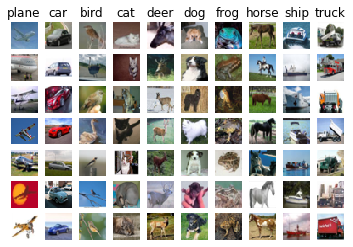

In [3]:
# Визуализируем некоторые изображения из набора данных.
# Показыважем несколько примеров изображений из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Разделение данных на обучающие (train), валидационные(val) и тестовые (test). 
# Создание небольшого множества данных для проведения экспериментов;
# Мы будем использовать это множество в процессе разработки, чтобы сократить время вычислений.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Валидационное множество содержит  num_validation элементов исходного обучающего множества.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Обучающее множество содержит num_train элементов исходного обучающего множества.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Создание небольшого множества для разработки (_dev), которое является частью обучающего множества
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


# Использование первых num_test элементов исходного тестового множества в качестве тестового подмножества
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Предобработка: реформатирование изображений в векторы
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Для проверки распечатаем размерности данных
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


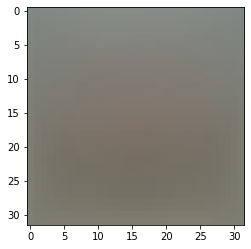

In [6]:
# Предобработка: вычитание среднего изображения
# 1: вычисляем среднее по обучающему множеству
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # вывод нескольких эл-тов
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) #визуализация среднего изображения
plt.show()

In [7]:
# 2: вычитаем среднее изображение из обучающего и других множеств
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# 3: добавляем еще одно измерение для смещения (трюк со смещением), чтобы
# при оптимизации мы занимались только оптимизацией одной матрицы весов W

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM классификатор

Ваш код для этой части задания должен быть написан в файле **cs231n/classifiers/linear_svm.py**. 

Как вы можете видеть, мы частично написали функцию `compute_loss_naive`, которая использует циклы for для оценки многоклассовой SVM функции потерь

In [9]:
# Оцените наивную реализацию функции потерь, которой мы снабдили Вас
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# генерация случайной матрицы весов с малыми значениями
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.344492


Градиент `grad`, возвращаемый функцией, вызываемой выше, в данный момент равен нулю.
Выведите формулы и реализуйте вычисление градиента для SVM функции потерь, реализуйте вычисления внутри функции `svm_loss_naive`. 

Чтобы убедиться, что вы правильно определили аналитический градиент, сравните его с численной оценкой градиента. Мы предоставили код, который сделает это за вас:


In [10]:
# После того как вы реализовали вычисление аналитического градиента, вычислите его с помощью кода ниже
# и выполните проверку градиента с помощью функции, которую мы вам предоставили

# Вычисляем функцию потерь и ее градиент по W.

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Вычислияем градиент вдоль нескольких случайно выбранных измерений и
# сравниваем с аналитически вычисляемым градиентом. Числа должны совпадать
# почти точно по всем измерениям.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Повторите проверку градиента с включенной регуляризацией
# Вы не забыли градиент регуляризационной составляющей функции потерь, не так ли?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 17.254035 analytic: 17.254035, relative error: 2.563790e-11
numerical: -6.278046 analytic: -6.278046, relative error: 6.500625e-11
numerical: -5.380979 analytic: -5.465298, relative error: 7.773945e-03
numerical: -11.272440 analytic: -11.272440, relative error: 2.697603e-12
numerical: -20.633726 analytic: -20.633726, relative error: 4.435958e-12
numerical: 15.303644 analytic: 15.303644, relative error: 1.502649e-11
numerical: -13.496654 analytic: -13.606641, relative error: 4.058067e-03
numerical: -8.631082 analytic: -8.631082, relative error: 5.249989e-12
numerical: 16.749311 analytic: 16.749311, relative error: 1.172444e-12
numerical: -7.640832 analytic: -7.607722, relative error: 2.171389e-03
numerical: -42.783960 analytic: -42.783960, relative error: 3.866519e-12
numerical: -47.713090 analytic: -47.713090, relative error: 3.663206e-12
numerical: -5.640158 analytic: -5.501840, relative error: 1.241414e-02
numerical: -32.521736 analytic: -32.521736, relative error: 2.89259

### Вопрос 1:
Возможно,что по некоторым измерениям результаты проверки градиента не будут точно совпадать. Как могло возникнуть такое расхождение? Нужно ли беспокоиться? Какой простой пример в одномерном случае, для которого  проверка градиента может завершиться неудачей? Как влияет значение отступа (margin) на частоту этого события? * Подсказка: SVM функция потерь не является строго говоря дифференцируемой *



**Ваш ответ:** *Отвечайте здесь*

In [11]:
# Реализуйте функцию svm_loss_vectorized; пока только вычислите потери;
# вычисление градиента реализуем ниже.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


# Потери должны совпадать, но ваша векторная реализация должна быть намного быстрее.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.344492e+00 computed in 0.058000s
Vectorized loss: 9.344492e+00 computed in 0.002999s
difference: 0.000000


In [12]:
# Завершите реализацию svm_loss_vectorized и вычислите градиент
# функции потерь с помощью векторизованного кода.

# Результаты счета наивной и векторизованной реализаций должны совпадать, но
# векторизванная версия должна быть  быстрее.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# Потери - это одно число, поэтому легко сравнивать вычисленные значения
# двумя реализациями. Градиенты, с другой стороны, являются матрицами, поэтому
# мы используем норму Фробениуса для их сравнения.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.068003s
Vectorized loss and gradient: computed in 0.002004s
difference: 0.000000


### Стохастический градиентный спуск (SGD- Stochastic Gradient Descent)

Теперь у нас есть векторизованные и эффективные выражения для оценки потерь и градиента. Аналитический градиент соответствуют численному градиенту. Поэтому мы готовы применить SGD для минимизации потерь.

In [13]:
# В файле linear_classifier.py реализуйте алгоритм SGD в функции
# LinearClassifier.train(), а затем запустите его с помощью кода ниже.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 407.429624
iteration 100 / 1500: loss 240.814527
iteration 200 / 1500: loss 147.143109
iteration 300 / 1500: loss 90.205154
iteration 400 / 1500: loss 55.778129
iteration 500 / 1500: loss 36.014734
iteration 600 / 1500: loss 23.945613
iteration 700 / 1500: loss 16.312369
iteration 800 / 1500: loss 11.643183
iteration 900 / 1500: loss 9.331041
iteration 1000 / 1500: loss 7.173483
iteration 1100 / 1500: loss 6.379536
iteration 1200 / 1500: loss 5.908640
iteration 1300 / 1500: loss 5.603251
iteration 1400 / 1500: loss 5.039359
That took 6.031224s


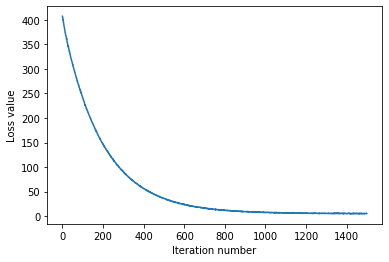

In [14]:
# Полезная стратегия отладки заключается в том, чтобы вычислять потери как функцию
# номер итерации:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Напишите функцию LinearSVM.predict и оцените эффективность как на
# тренировочном, так и на проверочном множествах
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.381082
validation accuracy: 0.378000


In [16]:
from cs231n.classifiers import LinearSVM
# Используйте валидационное мн-во для выбора гиперпараметров (коэффициента регуляризации и
# скорости обучения). Вы должны экспериментировать с различными значениями скорости обучения
# и коэффициента регуляризации; вы должны получить точность классификации около 0,4 валидационном мн-ве.
learning_rates = [2e-7, 4e-7, 5e-7, 6e-7, 7e-7]
regularization_strengths = [5e3, 7e3, 1e4, 15e3, 2e4, 3e4]


# results - является словарем, отображающим кортежи вида
# (learning_rate, regularization_strength) в кортежи вида
# (training_accuracy, validation_accuracy). Точность - это просто доля
# данных, которые правильно классифицированы.
results = {}
best_val = -1   # Наивысшая валидац. точность, которая наблюдалась до этого момента.
best_svm = None # Объект LinearSVM, для которого получена наивысшая валидац. точность.

################################################################################
# ЗАДАНИЕ:                                                                     #
# Напишите код, который выбирает лучшие гиперпараметры, используя              #
# валидационное мн-во. Для каждой комбинации гиперпараметров обучите           #
# линейный SVM на обучающем множестве, определите точность на обучающем и      #
# валидационном мн-вах, сохраните эти числа в словаре результатов. Кроме того, #
# сохраните лучшую валидац. точность в best_val, а объект LinearSVM., для      #
# которого достигнута эта точность, сохраните в best_svm.                      #
#                                                                              #
# Совет: вы должны использовать небольшое значение для num_iters при           #
# разработке своего валидационного кода, чтобы SVM не требовал много времени   #
# для обучения; как только вы будете уверены, что ваш код работает, вы должны  #
# повторно запустить валидационный код с большим значением для num_iters.      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1100, verbose=False)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        
        print('val accuracy: %f' % (val_accuracy, ))
        results[(lr, reg)] = (train_accuracy, val_accuracy)
################################################################################
#                              КОНЕЦ ВАШЕГО КОДА                               #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

val accuracy: 0.396000
val accuracy: 0.376000
val accuracy: 0.387000
val accuracy: 0.396000
val accuracy: 0.368000
val accuracy: 0.374000
val accuracy: 0.383000
val accuracy: 0.384000
val accuracy: 0.400000
val accuracy: 0.375000
val accuracy: 0.379000
val accuracy: 0.362000
val accuracy: 0.382000
val accuracy: 0.370000
val accuracy: 0.383000
val accuracy: 0.343000
val accuracy: 0.361000
val accuracy: 0.355000
val accuracy: 0.380000
val accuracy: 0.357000
val accuracy: 0.372000
val accuracy: 0.365000
val accuracy: 0.354000
val accuracy: 0.354000
val accuracy: 0.358000
val accuracy: 0.369000
val accuracy: 0.354000
val accuracy: 0.353000
val accuracy: 0.342000
val accuracy: 0.334000
lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.370143 val accuracy: 0.396000
lr 2.000000e-07 reg 7.000000e+03 train accuracy: 0.379796 val accuracy: 0.376000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 0.386755 val accuracy: 0.387000
lr 2.000000e-07 reg 1.500000e+04 train accuracy: 0.378939 val accur

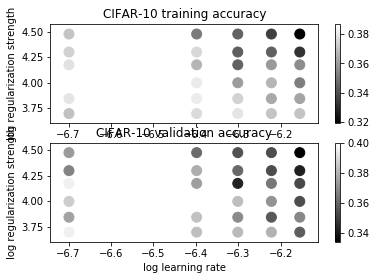

In [17]:
# Визуализация результатов кросс-валидации
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# отображение точности обучения
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# отображение точности валидации
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Оценивание лучшего SVM классификатора на тестовом мн-ве
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.366000


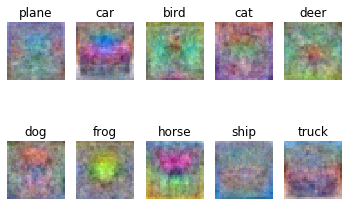

In [19]:
# Визуализация обученных весов для каждого класса.
# В зависимости от вашего выбора скорости обучения и силы регуляризации, это может
# выглядеть хорошо или плохо.


w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Вопрос  2:

Опишите ваши визуализированные веса SVM классификатора, и дайте краткое объяснение, почему они выглядят таким образом.

**Ваш ответ:** *Отвечайте здесь*